In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [11]:
df = pd.read_csv(r"C:\Users\rabea\Desktop\modified_train.csv")

# שינוי שם עמודת הטקסט
df = df.rename(columns={'fully_clean_text': 'Tweet'})
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,char_count,word_count,clean_text,HashtagCount,MentionCount,URLCount,...,has_@amazon,URLList,TweetDate,TweetWeekday,CleanLocation,Mentions,Hashtags,Tweet,text_len,token_lens
0,London -UK,2020-03-18,impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,279,48,impct of #coronavirus i hve sen hw civilizd pp...,3,0,0,...,False,[],2020-03-18,Wednesday,london -uk,[],"['#coronavirus', '#uk', '#uk']",impct of coronavirus i hve sen hw civilizd ppl...,48,79
1,"Victoria, BC, Canada",2020-03-21,"okay, so i just checked the drug prices for #p...",Positive,310,38,"okay, so i just checked the drug prices for #p...",9,0,0,...,False,['https://t.co/ovypmnsmax'],2020-03-21,Saturday,victoria,[],"['#plaquenil', '#aralen', '#chloroquine', '#ch...",okay so i just checked the drug prices for pla...,36,79
2,"Berlin, Deutschland",2020-04-02,eine wahre #coronageschichte:\r\r\n\r\r\nwenn ...,Neutral,263,34,eine wahre #coronageschichte:\r\r\n\r\r\nwenn ...,3,0,0,...,False,[],2020-04-02,Thursday,berlin,[],"['#coronageschichte', '#coronadiã', '#feelthejr']",eine wahre coronageschichte wenn dir an der su...,29,78
3,United Kingdom,2020-03-21,hiked prices in the face of the covid-19 crise...,Negative,296,52,hiked prices in the face of the covid-19 crise...,0,0,0,...,False,[],2020-03-21,Saturday,united kingdom,[],[],hiked prices in the face of the covid19 crises...,47,77
4,NaN,2020-04-09,for sell sterile disposable anti bacterial wet...,Negative,303,33,for sell sterile disposable anti bacterial wet...,13,0,0,...,False,['https://t.co/jizbddszet'],2020-04-09,Thursday,NaN,[],"['#disinfectant', '#covid', '#covid_19', '#cor...",for sell sterile disposable anti bacterial wet...,33,77


In [5]:
from transformers import AutoTokenizer

# Load BERTweet tokenizer (slow version — no offsets)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

tweet = "OMG sooo happy @john!! Check this: https://t.co/51bL8P6vZh 😂🔥"

# Tokenize
encoded = tokenizer(tweet)
tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"])

print("Tokens:")
print(tokens)

print("\nToken IDs:")
print(encoded["input_ids"])


C:\Users\rabea\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tokens:
['<s>', 'OM', 'G', 'Ġso', 'oo', 'Ġhappy', 'Ġ@', 'john', '!!', 'ĠCheck', 'Ġthis', ':', 'Ġhttps', '://', 't', '.', 'co', '/', '51', 'b', 'L', '8', 'P', '6', 'v', 'Z', 'h', 'ĠðŁĺ', 'Ĥ', 'ðŁ', 'Ķ', '¥', '</s>']

Token IDs:
[0, 3765, 534, 98, 3036, 1372, 787, 25304, 12846, 4254, 42, 35, 1205, 640, 90, 4, 876, 73, 4708, 428, 574, 398, 510, 401, 705, 1301, 298, 17841, 9264, 6569, 10674, 8210, 2]


In [52]:
from transformers import AutoTokenizer
import pandas as pd


text_col = "Tweet"  # or your column name

# Load BERTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

# Sample a few random tweets
sample_texts = df[text_col].dropna().sample(5, random_state=42)

for idx, tweet in enumerate(sample_texts, start=1):
    encoded = tokenizer(tweet)
    tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"])
    
    print(f"\n--- Tweet #{idx} ---")
    print(f"Original: {tweet}")
    print(f"Tokens  : {tokens}")
    print(f"Token IDs: {encoded['input_ids']}")



--- Tweet #1 ---
Original: coronavirus and team up to contact trace covid19 what brilliant collaboration in the waragainstvirus business consumer health technology url
Tokens  : ['<s>', 'cor', 'on', 'av', 'irus', 'Ġand', 'Ġteam', 'Ġup', 'Ġto', 'Ġcontact', 'Ġtrace', 'Ġcov', 'id', '19', 'Ġwhat', 'Ġbrilliant', 'Ġcollaboration', 'Ġin', 'Ġthe', 'Ġwar', 'against', 'v', 'irus', 'Ġbusiness', 'Ġconsumer', 'Ġhealth', 'Ġtechnology', 'Ġurl', '</s>']
Token IDs: [0, 7215, 261, 1469, 19473, 8, 165, 62, 7, 1511, 13946, 47268, 808, 1646, 99, 6967, 4918, 11, 5, 997, 22268, 705, 19473, 265, 2267, 474, 806, 46471, 2]

--- Tweet #2 ---
Original: hellosir i am gourav vishwakarmai am from berkhera pathani bhopal due to covid19 consumer exploitation is so increased please take any action regarding it
Tokens  : ['<s>', 'hell', 'os', 'ir', 'Ġi', 'Ġam', 'Ġgou', 'rav', 'Ġv', 'ish', 'w', 'ak', 'arm', 'ai', 'Ġam', 'Ġfrom', 'Ġb', 'erk', 'her', 'a', 'Ġpath', 'ani', 'Ġb', 'hop', 'al', 'Ġdue', 'Ġto', 'Ġcov', 'id', '19

### we check how it tokenizes emojis


In [54]:
from transformers import AutoTokenizer
import pandas as pd


text_col = "OriginalTweet"  # or your column name

# Load BERTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

# Sample a few random tweets
sample_texts = df[text_col].dropna().head(5)

for idx, tweet in enumerate(sample_texts, start=1):
    encoded = tokenizer(tweet)
    tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"])
    
    print(f"\n--- Tweet #{idx} ---")
    print(f"Original: {tweet}")
    print(f"Tokens  : {tokens}")
    print(f"Token IDs: {encoded['input_ids']}")



--- Tweet #1 ---
Original: impct of #coronavirus i hve sen hw civilizd ppl fighting ovr food commodities n toilet rolls in #uk, busy in stockpiling. mjrity of superstores gone out of stock, shlvs r empty. no oil,atta,vegetables,bread, fruits, rice
sems lke ppl will die nt of corona bt of strvtin in #uk.
Tokens  : ['<s>', 'imp', 'ct', 'Ġof', 'Ġ#', 'cor', 'on', 'av', 'irus', 'Ġi', 'Ġh', 've', 'Ġsen', 'Ġh', 'w', 'Ġcivil', 'iz', 'd', 'Ġp', 'pl', 'Ġfighting', 'Ġov', 'r', 'Ġfood', 'Ġcommodities', 'Ġn', 'Ġtoilet', 'Ġrolls', 'Ġin', 'Ġ#', 'uk', ',', 'Ġbusy', 'Ġin', 'Ġstockp', 'iling', '.', 'Ġm', 'j', 'rity', 'Ġof', 'Ġsuperst', 'ores', 'Ġgone', 'Ġout', 'Ġof', 'Ġstock', ',', 'Ġsh', 'lv', 's', 'Ġr', 'Ġempty', '.', 'Ġno', 'Ġoil', ',', 'atta', ',', 've', 'get', 'ables', ',', 'bread', ',', 'Ġfruits', ',', 'Ġrice', 'č', 'č', 'Ċ', 'se', 'ms', 'Ġl', 'ke', 'Ġp', 'pl', 'Ġwill', 'Ġdie', 'Ġn', 't', 'Ġof', 'Ġcor', 'ona', 'Ġb', 't', 'Ġof', 'Ġstr', 'vt', 'in', 'Ġin', 'Ġ#', 'uk', '.', '</s>']
Token IDs: [0, 11

## we can see that our tokenizer is not dealing with emojis, we try to fix that 

In [56]:
#checking if its a loading matter
df = pd.read_csv(r"C:\Users\rabea\Desktop\modified_train.csv", encoding="utf-8")

pd.set_option("display.max_colwidth", None)

# Now print again
print(df["OriginalTweet"].head())

0                                 impct of #coronavirus i hve sen hw civilizd ppl fighting ovr food commodities n toilet rolls in #uk, busy in stockpiling. mjrity of superstores gone out of stock, shlvs r empty. no oil,atta,vegetables,bread, fruits, rice\r\r\nsems lke ppl will die nt of corona bt of strvtin in #uk.
1             okay, so i just checked the drug prices for #plaquenil and #aralen - same #chloroquine #chloroquinephosphate \r\r\n#hydroxychloroquin drugs, and they go for 34 cents to 88 cents, per pill \r\r\n#azithromycine starts at $1.05/pill #fyi \r\r\n#hydroxychloroquineandazythromyacinnow \r\r\n#covid_19 ?? URL
2                                  eine wahre #coronageschichte:\r\r\n\r\r\nwenn dir an der supermarktkasse - ohne vorwarnung - das 2. taschentã¼cherpaket weg genommen wird, deine 6 schokoladen-ostereiertã¼ten, aber nicht halbiert werden. \r\r\nden vorgang nennt man!? \r\r\n#coronadiã¤t! ??\r\r\n_\r\r\n#feelthejr ?
3    hiked prices in the face of the covid-19 cri

In [36]:
!pip install chardet

import chardet

# Detect encoding from a sample of the file
with open(r"C:\Users\rabea\Desktop\modified_train.csv", "rb") as f:
    result = chardet.detect(f.read(100000))  # read first 100 KB
    print(result)


{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [66]:
def fix_mojibake(s: str) -> str:
    if not isinstance(s, str):
        return s
    try:
        fixed = s.encode("latin1").decode("utf-8")
        return fixed
    except Exception:
        return s

# simple emoji detector (enough for a quick scan)
def contains_emoji(s: str) -> bool:
    if not isinstance(s, str):
        return False
    # emojis typically live in higher Unicode planes
    return any(ord(ch) >= 0x1F000 for ch in s)

pd.set_option("display.max_colwidth", None)



In [68]:
# rows that likely contain mojibake: typical bytes you showed (â, ðŁ, etc.)
suspect_rx = re.compile(r"[â\u0096\u0092\u0093\u0094]|ð|Ł|ĺ|Ĥ|Ķ")
suspect_rows = df[df[text_col].fillna("").str.contains(suspect_rx)]
print("Suspected-mojibake rows (showing 3):")
print(suspect_rows[[text_col]].head(3))


Suspected-mojibake rows (showing 3):
                                                                                                                                                                                                                                                                                                                                    OriginalTweet
3             hiked prices in the face of the covid-19 crises are listed below:\r\r\nmas bazar Ã¢Â 265 whitchaple road, e1 1jn.\r\r\nsyldon bazaar Ã¢Â 84 plashet rd, e13 0rq.Ã¢Â \r\r\nfish bazar Ã¢Â 137 chapman street, e1 2ph.\r\r\nbondor bazar Ã¢Â 131-132 chapman street, e1 2ph.\r\r\nrahim brother limited Ã¢Â 216-218 mile end roa
16                                                                        achat local ??\r\r\nle URL encourage les quÃ£Â©bÃ£Â©cois Ã£Â  faire leur part pour aider les entreprises dÃ¢Âici en ciblant les produits et les commerces du quÃ£Â©bec. chaque dollar compte pour appuyer nos produi

In [70]:
fixed_col = f"{text_col}_fixed"
df[fixed_col] = df[text_col].apply(fix_mojibake)

changed = df[(df[text_col] != df[fixed_col]) & df[text_col].notna()][[text_col, fixed_col]]
print("Changed rows (first 5):")
print(changed.head(5))


Changed rows (first 5):
                                                                                                                                                                                                                                                                                                                          OriginalTweet  \
2                                       eine wahre #coronageschichte:\r\r\n\r\r\nwenn dir an der supermarktkasse - ohne vorwarnung - das 2. taschentÃ£Â¼cherpaket weg genommen wird, deine 6 schokoladen-ostereiertÃ£Â¼ten, aber nicht halbiert werden. \r\r\nden vorgang nennt man!? \r\r\n#coronadiÃ£Â¤t! ??\r\r\n_\r\r\n#feelthejr ?   
3   hiked prices in the face of the covid-19 crises are listed below:\r\r\nmas bazar Ã¢Â 265 whitchaple road, e1 1jn.\r\r\nsyldon bazaar Ã¢Â 84 plashet rd, e13 0rq.Ã¢Â \r\r\nfish bazar Ã¢Â 137 chapman street, e1 2ph.\r\r\nbondor bazar Ã¢Â 131-132 chapman street, e1 2ph.\r\r\nrahim brother limited Ã¢Â 216-218

In [72]:
# 1) Install ftfy once
!pip install -q ftfy

# 2) Apply to your column
import pandas as pd
from ftfy import fix_text

col = "OriginalTweet"  # change if needed

# If you already loaded df:
# df = pd.read_csv(r"C:\Users\rabea\Desktop\modified_train.csv", encoding="utf-8")

def fix_all(s):
    if not isinstance(s, str):
        return s
    # ftfy handles most double/triple-encoded junk
    t = fix_text(s)
    # If you still see literal "\r\r\n", replace them with real newlines:
    t = t.replace("\\r\\r\\n", "\n").replace("\\r\\n", "\n").replace("\\n", "\n")
    return t

fixed_col = f"{col}_fixed"
df[fixed_col] = df[col].apply(fix_all)

# Show before→after for a few rows that changed
changed = df.loc[(df[col] != df[fixed_col]) & df[col].notna(), [col, fixed_col]]
pd.set_option("display.max_colwidth", None)
print(changed.head(5))


                                                                                                                                                                                                                                                                                                                         OriginalTweet  \
0                                           impct of #coronavirus i hve sen hw civilizd ppl fighting ovr food commodities n toilet rolls in #uk, busy in stockpiling. mjrity of superstores gone out of stock, shlvs r empty. no oil,atta,vegetables,bread, fruits, rice\r\r\nsems lke ppl will die nt of corona bt of strvtin in #uk.   
1                       okay, so i just checked the drug prices for #plaquenil and #aralen - same #chloroquine #chloroquinephosphate \r\r\n#hydroxychloroquin drugs, and they go for 34 cents to 88 cents, per pill \r\r\n#azithromycine starts at $1.05/pill #fyi \r\r\n#hydroxychloroquineandazythromyacinnow \r\r\n#covid_19 ?? URL   
2         

In [74]:
from ftfy import fix_text

def fix_full(s):
    if not isinstance(s, str):
        return s
    # Step 1: ftfy main fix
    s = fix_text(s)
    # Step 2: secondary Latin1→UTF8 repair for leftovers
    try:
        s = s.encode("latin1").decode("utf-8")
    except:
        pass
    return s

df["OriginalTweet_fixed"] = df["OriginalTweet"].apply(fix_full)

In [76]:
from transformers import AutoTokenizer
import pandas as pd

# Assuming df exists and df["OriginalTweet_fixed"] is created
text_col = "OriginalTweet_fixed"

# Load BERTweet-LARGE tokenizer (slow tokenizer is fine; matches model)
tok = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)

def contains_emoji(s: str) -> bool:
    if not isinstance(s, str):
        return False
    # quick heuristic for emojis (most are above this code point)
    return any(ord(ch) >= 0x1F000 for ch in s)

def show_tokenization(text: str):
    enc = tok(text)
    tokens = tok.convert_ids_to_tokens(enc["input_ids"])
    print("TEXT:\n", text)
    print("\nTOKENS:\n", tokens)
    print("\nTOKEN IDs:\n", enc["input_ids"])
    print("\n" + "-"*90 + "\n")

# 1) Prefer rows that contain emojis (if any)
emoji_rows = df.loc[df[text_col].apply(contains_emoji), text_col].head(5)

# 2) If none found, just take the first 5 fixed tweets
rows_to_check = emoji_rows if len(emoji_rows) > 0 else df[text_col].head(5)

for i, txt in enumerate(rows_to_check, 1):
    print(f"=== Tweet #{i} ===")
    show_tokenization(txt)


=== Tweet #1 ===
TEXT:
 impct of #coronavirus i hve sen hw civilizd ppl fighting ovr food commodities n toilet rolls in #uk, busy in stockpiling. mjrity of superstores gone out of stock, shlvs r empty. no oil,atta,vegetables,bread, fruits, rice

sems lke ppl will die nt of corona bt of strvtin in #uk.

TOKENS:
 ['<s>', 'imp', 'ct', 'Ġof', 'Ġ#', 'cor', 'on', 'av', 'irus', 'Ġi', 'Ġh', 've', 'Ġsen', 'Ġh', 'w', 'Ġcivil', 'iz', 'd', 'Ġp', 'pl', 'Ġfighting', 'Ġov', 'r', 'Ġfood', 'Ġcommodities', 'Ġn', 'Ġtoilet', 'Ġrolls', 'Ġin', 'Ġ#', 'uk', ',', 'Ġbusy', 'Ġin', 'Ġstockp', 'iling', '.', 'Ġm', 'j', 'rity', 'Ġof', 'Ġsuperst', 'ores', 'Ġgone', 'Ġout', 'Ġof', 'Ġstock', ',', 'Ġsh', 'lv', 's', 'Ġr', 'Ġempty', '.', 'Ġno', 'Ġoil', ',', 'atta', ',', 've', 'get', 'ables', ',', 'bread', ',', 'Ġfruits', ',', 'Ġrice', 'Ċ', 'Ċ', 'se', 'ms', 'Ġl', 'ke', 'Ġp', 'pl', 'Ġwill', 'Ġdie', 'Ġn', 't', 'Ġof', 'Ġcor', 'ona', 'Ġb', 't', 'Ġof', 'Ġstr', 'vt', 'in', 'Ġin', 'Ġ#', 'uk', '.', '</s>']

TOKEN IDs:
 [0, 11850, 3

In [84]:
!pip install wordninja

import re
import wordninja  # or wordsegment

def segment_hashtag(text):
    def split_tag(match):
        tag = match.group(1)
        # If long, try splitting
        if len(tag) > 10:
            return '#' + ' '.join(wordninja.split(tag))
        return '#' + tag
    return re.sub(r"#(\w+)", split_tag, text)

tweet = "This is about #WarAgainstVirus and #covid19"
print(segment_hashtag(tweet))

     ---------------------------------------- 0.0/541.6 kB ? eta -:--:--
      --------------------------------------- 10.2/541.6 kB ? eta -:--:--
     - ----------------------------------- 20.5/541.6 kB 110.1 kB/s eta 0:00:05
     -- ---------------------------------- 41.0/541.6 kB 219.4 kB/s eta 0:00:03
     ---- -------------------------------- 71.7/541.6 kB 328.6 kB/s eta 0:00:02
     ---------- ------------------------- 153.6/541.6 kB 573.4 kB/s eta 0:00:01
     ------------------- ---------------- 286.7/541.6 kB 930.9 kB/s eta 0:00:01
     ---------------------------- --------- 399.4/541.6 kB 1.1 MB/s eta 0:00:01
     ---------------------------- --------- 399.4/541.6 kB 1.1 MB/s eta 0:00:01
     -------------------------------------  532.5/541.6 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 541.6/541.6 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wordninja: 

In [91]:
import re, html
from ftfy import fix_text
import wordninja  # you said it's installed

def clean_tweet(
    text: str,
    *,
    segment_long_hashtags: bool = True,
    hashtag_split_min_len: int = 11,   # segment tags longer than this
    url_token: str = "HTTPURL",
    mention_token: str = "@USER",
    normalize_elongation: bool = True,
    normalize_bullets: bool = True,
    canonicalize_covid: bool = True
) -> str:
    """
    BERTweet-friendly cleaner:
      - fixes encoding (ftfy)
      - keeps emojis & punctuation
      - keeps '#' and (optionally) segments long hashtags into words while preserving '#'
      - replaces @mentions → @USER, URLs → HTTPURL
      - lightly normalizes elongated spellings (soooo → soo)
      - optional bullet normalization and COVID canonicalization
    """
    if not isinstance(text, str):
        return text

    # 0) fix common encoding issues first
    s = fix_text(text)

    # 1) replace mentions & urls with stable placeholders
    s = re.sub(r"@\w+", mention_token, s)
    s = re.sub(r"(https?://\S+|www\.\S+)", url_token, s)

    # 2) decode HTML entities (&amp; → &)
    s = html.unescape(s)

    # 3) optional: segment long hashtags but keep '#'
    if segment_long_hashtags:
        def split_tag(m):
            tag = m.group(1)  # the part after '#'
            # keep underscores (model can handle), but if very long, segment alphanum chunk
            raw = tag.replace("’", "'")  # minor tidy
            if len(raw) >= hashtag_split_min_len:
                # segment letters/numbers; keep underscores as separators
                pieces = []
                for chunk in re.split(r"(_+)", raw):  # keep underscores as their own "chunks"
                    if chunk.startswith("_"):
                        pieces.append(chunk)  # preserve underscores
                    else:
                        if len(chunk) >= hashtag_split_min_len:
                            pieces.extend(wordninja.split(chunk))
                        else:
                            pieces.append(chunk)
                # collapse underscores to single spaces around words (cleaner for tokenizer)
                glued = []
                for p in pieces:
                    if p.startswith("_"):
                        glued.append(" ")              # translate long underscores to space
                    else:
                        glued.append(p)
                return "#" + " ".join([x for x in " ".join(glued).split() if x])
            return "#" + tag
        s = re.sub(r"#([A-Za-z0-9_]+)", split_tag, s)

    # 4) optional: canonicalize common COVID variants → "covid 19"
    if canonicalize_covid:
        s = re.sub(r"\b(corona\s*virus|covid[\-_\s]?19|covid19|covid)\b", "covid 19", s, flags=re.IGNORECASE)

    # 6) optional: tame elongated characters (soooo → soo), keep emphasis but reduce rare subwords
    if normalize_elongation:
        s = re.sub(r"(.)\1{2,}", r"\1\1", s)

    # 7) whitespace tidy
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [97]:
# assuming your df is named `train` and column is 'OriginalTweet'
df["clean_eda_2"] = df["OriginalTweet"].apply(clean_tweet)

# quick peek
print(df["clean_eda_2"].head(5))


0                        impct of #covid 19 i hve sen hw civilizd ppl fighting ovr food commodities n toilet rolls in #uk, busy in stockpiling. mjrity of superstores gone out of stock, shlvs r empty. no oil,atta,vegetables,bread, fruits, rice sems lke ppl will die nt of corona bt of strvtin in #uk.
1    okay, so i just checked the drug prices for #plaquenil and #aralen - same #chloroquine #chloroquine phosphate #hydroxy chl oro quin drugs, and they go for 34 cents to 88 cents, per pill #a zi th romy cine starts at $1.05/pill #fyi #hydroxy chloroquine and azy th romy ac in now #covid 19 ?? URL
2                                                 eine wahre #corona geschichte: wenn dir an der supermarktkasse - ohne vorwarnung - das 2. taschentã¼cherpaket weg genommen wird, deine 6 schokoladen-ostereiertã¼ten, aber nicht halbiert werden. den vorgang nennt man!? #coronadiã¤t! ?? _ #feelthejr ?
3                       hiked prices in the face of the covid 19 crises are listed below: mas bazar 

### droping non-english tweets

In [99]:
!pip install langdetect

from langdetect import detect, DetectorFactory
import pandas as pd

DetectorFactory.seed = 0  # for reproducible results

def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

# Example: drop non-English
df = df[df["clean_eda_2"].apply(is_english)].reset_index(drop=True)

print(df["clean_eda_2"].head(5))


     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/981.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/981.5 kB ? eta -:--:--
     - ----------------------------------- 41.0/981.5 kB 388.9 kB/s eta 0:00:03
     ---- ------------------------------- 122.9/981.5 kB 798.9 kB/s eta 0:00:02
     ---------- --------------------------- 276.5/981.5 kB 1.3 MB/s eta 0:00:01
     ------------- ------------------------ 337.9/981.5 kB 1.5 MB/s eta 0:00:01
     --------------- ---------------------- 409.6/981.5 kB 1.3 MB/s eta 0:00:01
     ---------------------------- --------- 727.0/981.5 kB 2.0 MB/s eta 0:00:01
     -------------------------------------  972.8/981.5 kB 2.5 MB/s eta 0:00:01
     -------------------------------------- 981.5/981.5 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langdetect: filen

### checking token length to prepare for training

Tokenizing: 100%|██████████| 40879/40879 [00:19<00:00, 2147.85it/s]


count    40879.000000
mean        46.161599
std         16.613145
min          6.000000
25%         34.000000
50%         47.000000
75%         59.000000
max        109.000000
dtype: float64

Percentiles:
50th percentile: 47
75th percentile: 59
90th percentile: 67
95th percentile: 72
99th percentile: 82
100th percentile: 109


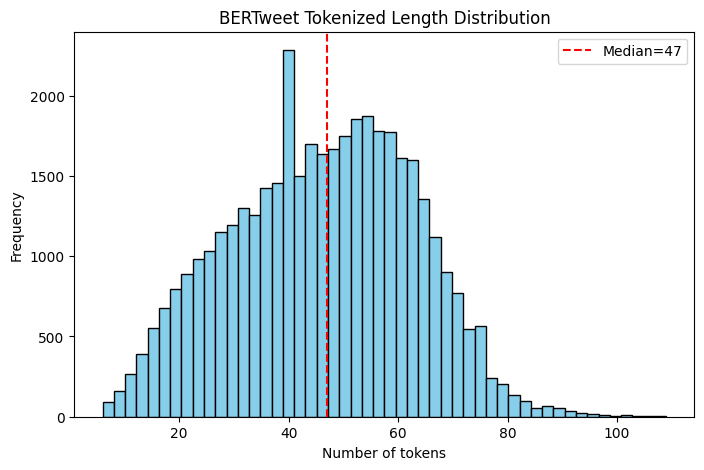

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm

# 1) Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)

# 2) Column to check (use your cleaned column)
text_col = "clean_eda_2"  # replace with the name of your cleaned text column

# 3) Get tokenized lengths
lengths = []
for txt in tqdm(df[text_col], desc="Tokenizing"):
    if isinstance(txt, str) and txt.strip():
        ids = tokenizer(txt)["input_ids"]
        lengths.append(len(ids))
    else:
        lengths.append(0)  # handle NaNs/empties

# 4) Convert to Series for easy stats
lengths_series = pd.Series(lengths)

# 5) Summary stats
print(lengths_series.describe())
print("\nPercentiles:")
for p in [50, 75, 90, 95, 99, 100]:
    print(f"{p}th percentile: {lengths_series.quantile(p/100):.0f}")

# 6) Plot distribution
plt.figure(figsize=(8,5))
plt.hist(lengths_series, bins=50, color='skyblue', edgecolor='black')
plt.title("BERTweet Tokenized Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.axvline(lengths_series.median(), color='red', linestyle='--', label=f"Median={lengths_series.median():.0f}")
plt.legend()
plt.show()


In [113]:
df.to_csv(r"C:\Users\rabea\Desktop\eda2.csv", index=False)
